In [29]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
from financial_common.indicator.indicator import Indicator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.mstats import winsorize

In [31]:
## Import standard packages
from datetime import timedelta, datetime, timezone
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [32]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [33]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [34]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [35]:
rolling_window = 10
market.connect()
prices = []
skips = 1
model_end = 2021
backtest_end = 2025
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price = price[(price["date"]>=datetime(model_end-1,10,31,tzinfo=timezone.utc)-timedelta(days=rolling_window*2)) & (price["year"]<backtest_end)]
            price.sort_values("date", inplace=True)
            price["dividend"] = 0
            price["coefficient_of_variation"] = 1
            price = Metric.MARKETCAP.calculate(price,timeframe=rolling_window,live=False)
            price = Metric.STANDARD_DEV.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_OPEN.calculate(price,timeframe=rolling_window)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11273/11273 [02:48<00:00, 66.83it/s]


In [36]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "option_price"
                                                            ]
                                                            ,num_of_groups=[1]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[1]
                                                            ,min_prices=[0.01]
                                                            ,max_market_caps = [10000000]
                                                            ,min_market_caps = [1000000]
                                                            ,stoplosses=[1]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "day" and "top_blacklist" in portfolio.selection_type.label \
        and portfolio.allocation_type.label == "equal" \
        and portfolio.ranking_metric != "optimal" \
        and portfolio.grouping_type.value == "standard_dev" \
        and portfolio.position_type.label == "long" and portfolio.max_price > portfolio.min_price:
        filtered_portfolios.append(portfolio)

In [37]:
from financial_common.indicator.indicator import Indicator
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        indicator_class = Indicator.indicator_type_factory(portfolio.ranking_metric)
        simulation = pd.concat(prices)
        simulation = simulation.sort_values("date")
        simulation = simulation.groupby("ticker").apply(lambda x: indicator_class.calculate(x, portfolio.rolling_window,live=False)).reset_index(drop=True).dropna()
        trades = portfolio.trades(simulation.copy())
        trades = p.additional_date_columns(trades)
        trades.sort_values("date")
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:14<00:00, 74.75s/it]


In [38]:
a = pd.DataFrame(analysises)

In [39]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","max_market_cap","min_market_cap","timeframe","selection_percentage","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,stoploss,num_of_groups,max_price,min_price,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
0,option_price,long,STANDARD_DEV,top_blacklist,equal,1,1,1,0.01,1,1.043856,434876.819559,0.999602,90.360455,0.011552,-107.889448,0.328328,-3.79606


In [40]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades).sort_values("date")
portfolio = pm.portfolio(trades,benchmark)
trades["derpclose"] = trades["adjclose"].round(1)

In [41]:
trades[["adjclose","option_price","unweighted_return"]].corr()

,adjclose,option_price,unweighted_return
adjclose,1.000000,-0.133764,0.003337
option_price,-0.133764,1.000000,0.029544
unweighted_return,0.003337,0.029544,1.000000


In [42]:
trades

,year,day,ticker,date,weekday,market_cap,open,adjclose,sell_price,standard_dev,...,position_type,weight,unweighted_return,winsorized_return,weighted_return,return,month,quarter,week,derpclose
0,2020,315,DXLG,2020-11-10 00:00:00+00:00,1,9.491327e+06,0.3280,0.3100,0.2948,0.029944,...,1.0,1.0,0.950968,0.950968,-0.049032,-0.000361,11,4,46,0.3
1,2020,316,DXLG,2020-11-11 00:00:00+00:00,2,2.631621e+06,0.2948,0.3008,0.3040,0.031536,...,1.0,1.0,1.010638,1.010638,0.010638,0.000078,11,4,46,0.3
2,2020,317,RAVE,2020-11-12 00:00:00+00:00,3,2.449782e+06,0.7158,0.7002,0.7351,0.059040,...,1.0,1.0,1.049843,1.049843,0.049843,0.000367,11,4,46,0.7
3,2020,318,PR,2020-11-13 00:00:00+00:00,4,3.179902e+06,0.6583,0.7016,0.7458,0.046265,...,1.0,1.0,1.062999,1.062999,0.062999,0.000464,11,4,46,0.7
4,2020,321,FTEK,2020-11-16 00:00:00+00:00,0,2.904830e+06,1.0300,0.9600,0.9600,0.215476,...,1.0,1.0,1.000000,1.000000,0.000000,0.000000,11,4,47,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,2024,358,LDTC,2024-12-23 00:00:00+00:00,0,1.786973e+06,0.7899,0.7900,0.7753,0.372983,...,1.0,1.0,0.981392,0.981392,-0.018608,-0.000137,12,4,52,0.8
966,2024,359,BURU,2024-12-24 00:00:00+00:00,1,1.067755e+06,0.4051,0.4329,0.4400,0.088520,...,1.0,1.0,1.016401,1.016401,0.016401,0.000121,12,4,52,0.4
967,2024,361,GALT,2024-12-26 00:00:00+00:00,3,1.429698e+06,0.8388,0.8701,0.9010,0.565526,...,1.0,1.0,1.035513,1.035513,0.035513,0.000261,12,4,52,0.9
968,2024,362,PDYNW,2024-12-27 00:00:00+00:00,4,1.399362e+06,1.2500,0.9850,1.3900,0.193267,...,1.0,1.0,1.411168,1.091954,0.411168,0.000677,12,4,52,1.0


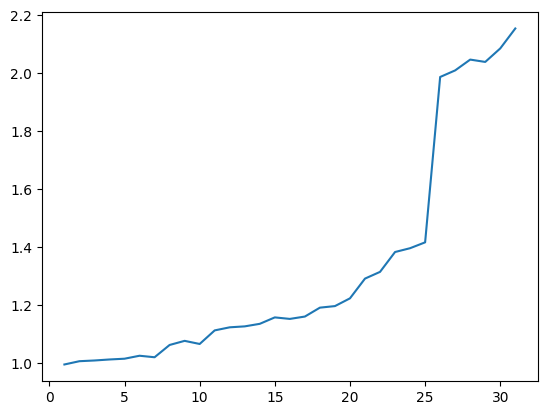

In [43]:
portfolio["weekday"] = portfolio["date"].dt.weekday
portfolio["month"] = portfolio["date"].dt.month
portfolio["week"] = [x.week for x in portfolio["date"]]
portfolio["month_day"] = portfolio["date"].dt.day

metric = "month_day"
view = portfolio.groupby(metric).mean().reset_index().sort_values(metric)
view["raw_pnl"] = view["weighted_return"].cumprod()
plt.plot(view[metric],view["raw_pnl"])
plt.show()

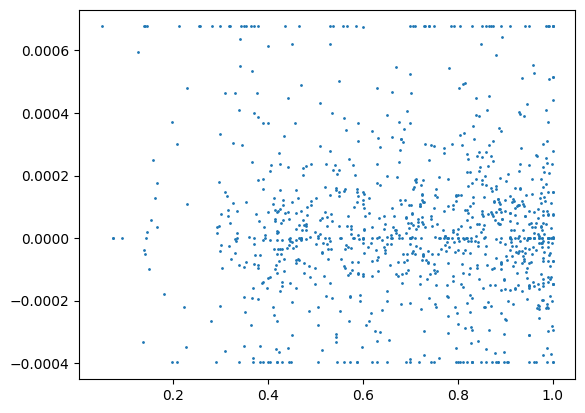

In [44]:
plt.scatter(trades["adjclose"],trades["return"],s=1)
plt.show()

In [45]:
orivault.connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()